# Pytorch- IRIS Dataset

Now we will look at using Pytorch to perform classification on the Iris dataset. In order to do this, we will build a multilayered neural network model.

In [22]:
# Import libralies
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
import tqdm

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

The first step is to load the dataset and split the data into the training and test parts.

In [23]:
# load IRIS dataset

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
data_train, data_test, labels_train, labels_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

We will build a model with *two* hidden layers (3 layers of weights). So, we create the model class by combining a sequence of linear fully connected layers.

In [24]:
class Model(nn.Module):
    # define nn
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)

        return X

Now, we should define the optimizer and loss function. Besides, to use the model class, we should create an object from the class.

In [25]:
model     = Model(data_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

So, it is time to define the training loop and train the model over the training samples, and then evaluating the model over the test data.

In [26]:
epochs  = 100
data_train = Variable(torch.from_numpy(data_train)).float()
labels_train = Variable(torch.from_numpy(labels_train)).long()
data_test  = Variable(torch.from_numpy(data_test)).float()
labels_test  = Variable(torch.from_numpy(labels_test)).long()

loss_list     = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
    y_pred = model(data_train)
    loss = loss_fn(y_pred, labels_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(data_test)
        correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 552.87it/s]


Now, we can visualize the validation results. First, in the following part, we will plot the validation accuracy and validation loss over the epochs. 

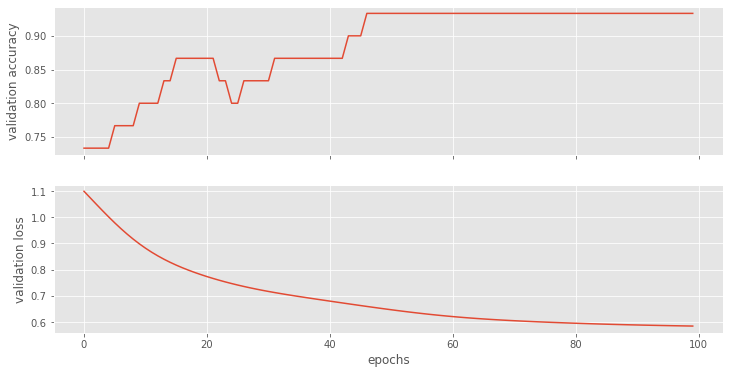

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

Then, we plot the receiver operating characteristic curve, or ROC curve, that is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 

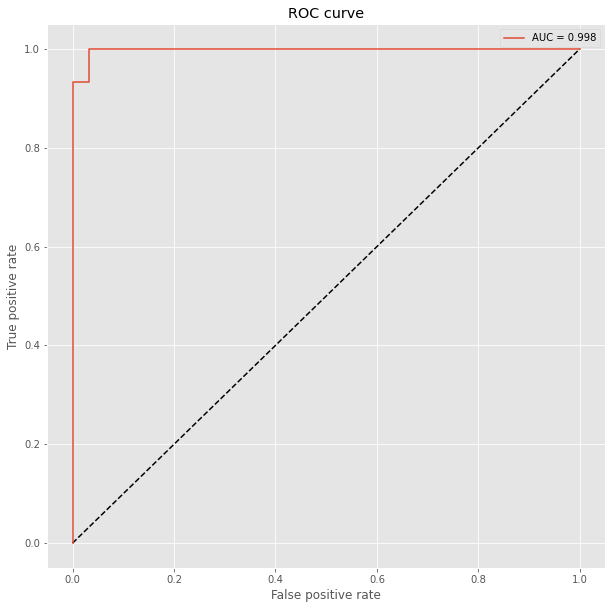

In [28]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(labels_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(data_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

predict_out = model(data_test)
_, predict_y = torch.max(predict_out, 1)

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();


Finally, we use the precision-recall metrics to evaluate the performance of the model.

In [29]:
# Compute the precision.
print ('prediction accuracy', accuracy_score(labels_test.data, predict_y.data))

# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print ('macro precision', precision_score(labels_test.data, predict_y.data, average='macro'))
# Calculate metrics globally by counting the total true positives, false negatives and false positives.
print ('micro precision', precision_score(labels_test.data, predict_y.data, average='micro'))
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print ('macro recall', recall_score(labels_test.data, predict_y.data, average='macro'))
# Calculate metrics globally by counting the total true positives, false negatives and false positives.
print ('micro recall', recall_score(labels_test.data, predict_y.data, average='micro'))

prediction accuracy 0.9333333333333333
macro precision 0.9212962962962963
micro precision 0.9333333333333333
macro recall 0.9345238095238096
micro recall 0.9333333333333333
